In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import glob
import random
from os import listdir
from sklearn.metrics import classification_report
import tensorflow as tf
import keras.utils as image

2024-06-14 22:38:43.500396: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-14 22:38:44.743508: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
breast_img = glob.glob('images/IDC/**/*.png', recursive = True)

for imgname in breast_img[:3]:
    print(imgname)

images/IDC/9078/0/9078_idx5_x3251_y1951_class0.png
images/IDC/9078/0/9078_idx5_x651_y1901_class0.png
images/IDC/9078/0/9078_idx5_x2751_y2301_class0.png


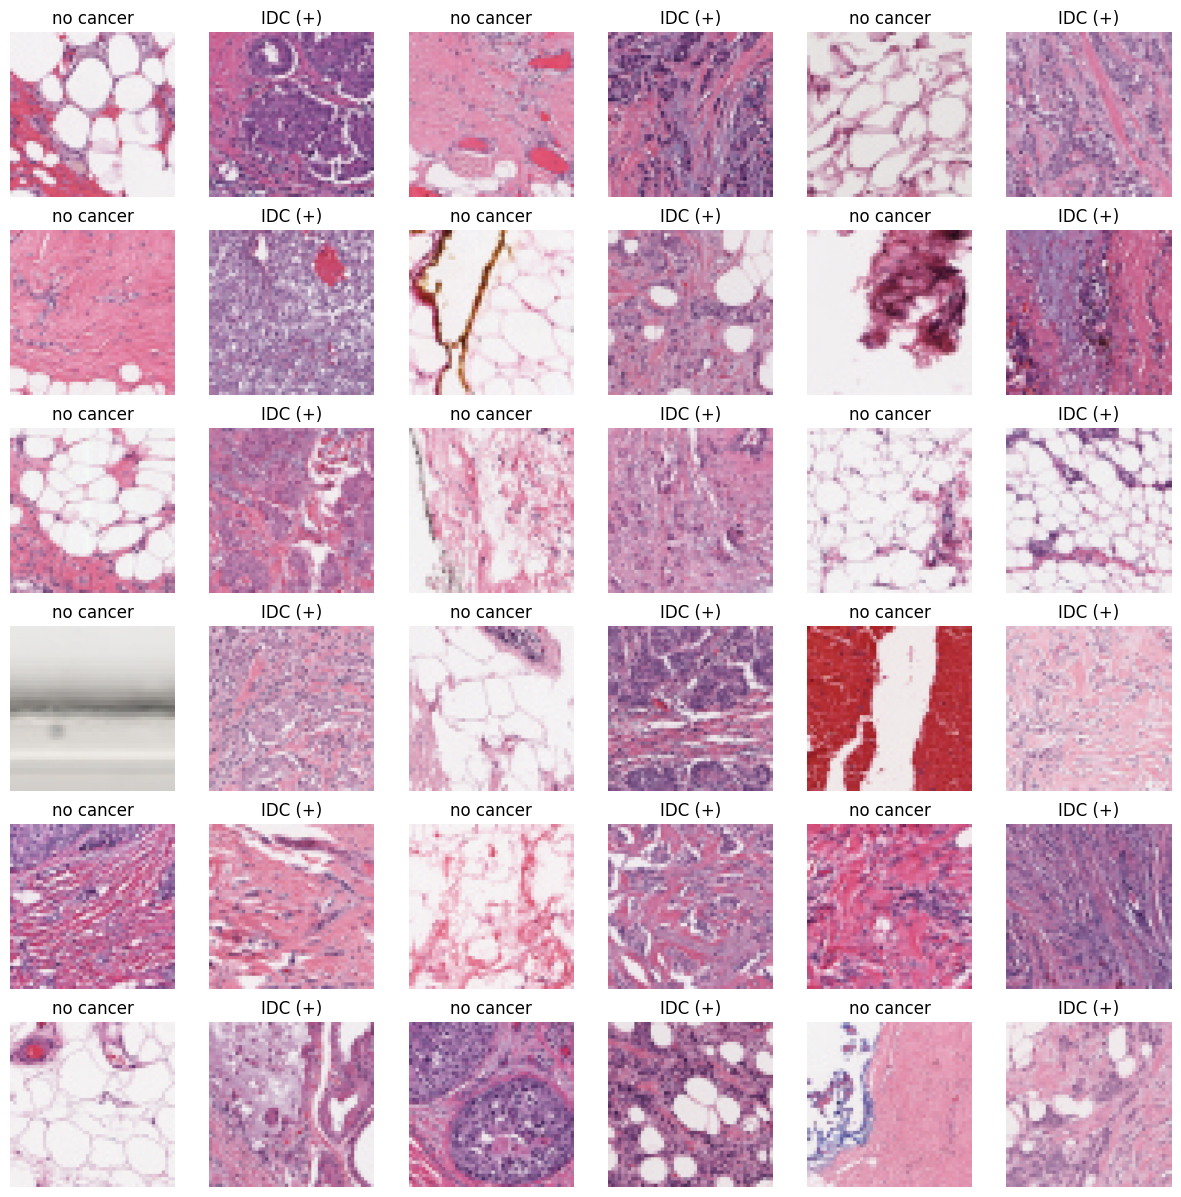

In [3]:
# Separate images based on label in the filename
N_IDC = []
P_IDC = []

for img in breast_img:
    if img[-5] == '0':
        N_IDC.append(img)
    elif img[-5] == '1':
        P_IDC.append(img)

# Plot some sample images
plt.figure(figsize=(15, 15))

some_non = np.random.randint(0, len(N_IDC), 18)
some_can = np.random.randint(0, len(P_IDC), 18)

s = 0
for num in some_non:
    img = image.load_img((N_IDC[num]), target_size=(100, 100))
    img = image.img_to_array(img)
    plt.subplot(6, 6, 2*s+1)
    plt.axis('off')
    plt.title('no cancer')
    plt.imshow(img.astype('uint8'))
    s += 1

s = 1
for num in some_can:
    img = image.load_img((P_IDC[num]), target_size=(100, 100))
    img = image.img_to_array(img)
    plt.subplot(6, 6, 2*s)
    plt.axis('off')
    plt.title('IDC (+)')
    plt.imshow(img.astype('uint8'))
    s += 1

In [4]:
# Subset the negative samples to balance the dataset
NewN_IDC = N_IDC[:78786]
print(len(NewN_IDC))
print(len(P_IDC))

78786
78786


In [5]:
# Prepare image arrays
non_img_arr = []
can_img_arr = []

for img in NewN_IDC:
    n_img = cv2.imread(img, cv2.IMREAD_COLOR)
    n_img_size = cv2.resize(n_img, (50, 50), interpolation=cv2.INTER_LINEAR)
    non_img_arr.append([n_img_size, 0])

for img in P_IDC:
    c_img = cv2.imread(img, cv2.IMREAD_COLOR)
    c_img_size = cv2.resize(c_img, (50, 50), interpolation=cv2.INTER_LINEAR)
    can_img_arr.append([c_img_size, 1])

print(len(non_img_arr))
print(len(can_img_arr))
print(len(non_img_arr) + len(can_img_arr))

78786
78786
157572


In [6]:
# Combine and shuffle the image arrays
breast_img_arr = non_img_arr[:12389] + can_img_arr[:12389]
random.shuffle(breast_img_arr)

# Extract features and labels
X = [feature for feature, label in breast_img_arr]
y = [label for feature, label in breast_img_arr]

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

print(X.shape)
print(y.shape)

(24778, 50, 50, 3)
(24778,)


In [7]:
def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of IDC(-) Images: {}'.format(np.sum(b==0)))
    print('Number of IDC(+) Images: {}'.format(np.sum(b==1)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))
describeData(X,y)

Total number of images: 24778
Number of IDC(-) Images: 12389
Number of IDC(+) Images: 12389
Image shape (Width, Height, Channels): (50, 50, 3)


In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3)

from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (17344, 50, 50, 3)
Testing Data Shape: (7434, 50, 50, 3)


In [9]:
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import itertools

In [10]:
early_stop=EarlyStopping(monitor='val_loss',patience=5)
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(50, 50, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.3))
model.add(Dense(24, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(2, activation='softmax'))

/home/mdsme/Documents/MiRA/MachineLearning/v1/breast_cancerv1/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-06-14 22:39:29.357146: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-14 22:39:29.543891: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tens

In [11]:
model.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 50, 50, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 50, 50, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 50, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 25, 25, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 25, 25, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 25, 25, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 25, 25, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 24)             │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │            5

 Total params: 2,514,410 (9.59 MB)

 Trainable params: 2,513,642 (9.59 MB)

 Non-trainable params: 768 (3.00 KB)

In [13]:
history = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = 40, batch_size = 35)

Epoch 1/40


2024-06-14 22:39:30.232022: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 130080000 exceeds 10% of free system memory.
2024-06-14 22:39:36.502914: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 14929920 exceeds 10% of free system memory.
2024-06-14 22:39:36.504418: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 14929920 exceeds 10% of free system memory.
2024-06-14 22:39:36.558828: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 27360000 exceeds 10% of free system memory.
2024-06-14 22:39:36.559160: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 27360000 exceeds 10% of free system memory.


496/496 ━━━━━━━━━━━━━━━━━━━━ 159s 309ms/step - accuracy: 0.7753 - loss: 0.5117 - val_accuracy: 0.7924 - val_loss: 0.4708
Epoch 2/40
496/496 ━━━━━━━━━━━━━━━━━━━━ 159s 320ms/step - accuracy: 0.8208 - loss: 0.4135 - val_accuracy: 0.7405 - val_loss: 0.5662
Epoch 3/40
496/496 ━━━━━━━━━━━━━━━━━━━━ 167s 336ms/step - accuracy: 0.8311 - loss: 0.3895 - val_accuracy: 0.7482 - val_loss: 0.5435
Epoch 4/40
496/496 ━━━━━━━━━━━━━━━━━━━━ 159s 321ms/step - accuracy: 0.8469 - loss: 0.3618 - val_accuracy: 0.7939 - val_loss: 0.4810
Epoch 5/40
496/496 ━━━━━━━━━━━━━━━━━━━━ 159s 320ms/step - accuracy: 0.8445 - loss: 0.3572 - val_accuracy: 0.8177 - val_loss: 0.4395
Epoch 6/40
496/496 ━━━━━━━━━━━━━━━━━━━━ 160s 322ms/step - accuracy: 0.8417 - loss: 0.3620 - val_accuracy: 0.8102 - val_loss: 0.4545
Epoch 7/40
496/496 ━━━━━━━━━━━━━━━━━━━━ 160s 323ms/step - accuracy: 0.8498 - loss: 0.3386 - val_accuracy: 0.7366 - val_loss: 0.5777
Epoch 8/40
496/496 ━━━━━━━━━━━━━━━━━━━━ 160s 323ms/step - accuracy: 0.8576 - loss: 0.32

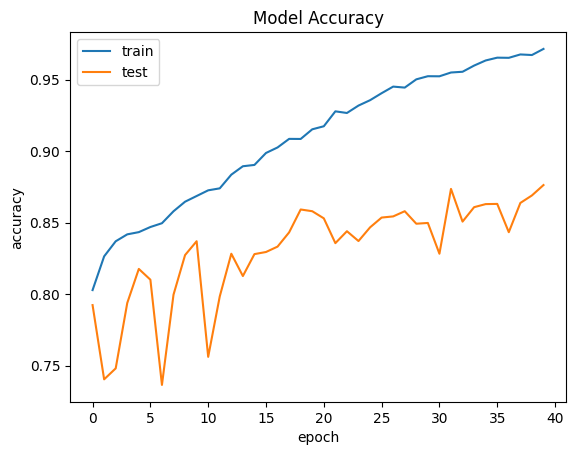

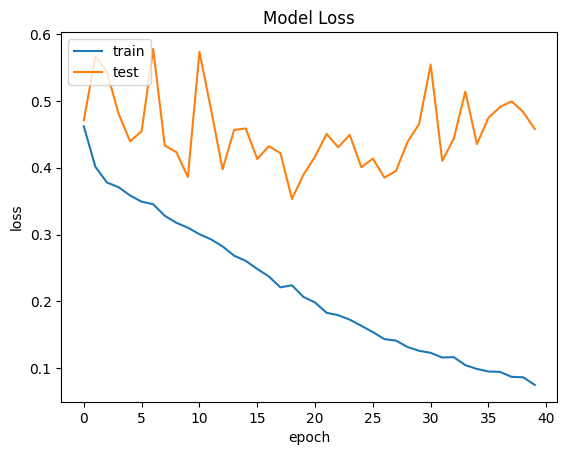

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

233/233 ━━━━━━━━━━━━━━━━━━━━ 16s 68ms/step


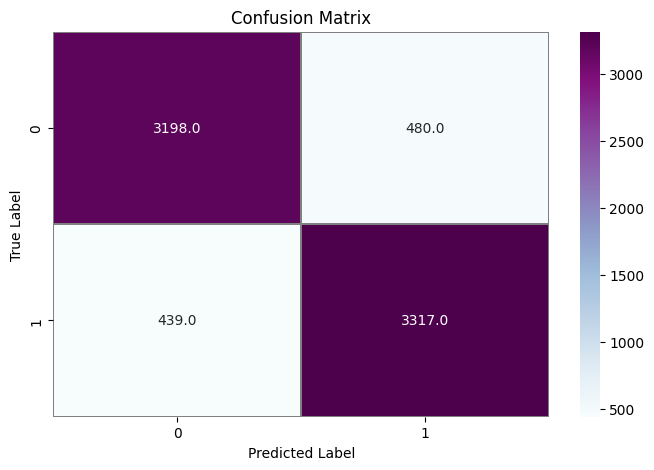

In [15]:
from sklearn.metrics import accuracy_score
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(Y_test,axis = 1)
#accuracy=accuracy_score(y_true=Y_true, y_pred=Y_pred)
#print(accuracy)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
f,ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

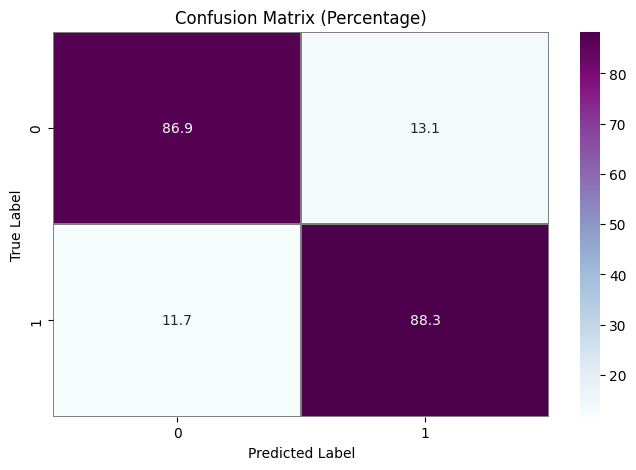

In [16]:
from sklearn.metrics import accuracy_score, confusion_matrix
#Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# calculate the percentage
confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_mtx_percent, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

In [17]:
model.evaluate(X_test,Y_test)

233/233 ━━━━━━━━━━━━━━━━━━━━ 16s 70ms/step - accuracy: 0.8733 - loss: 0.4905


[0.45801910758018494, 0.8763787746429443]

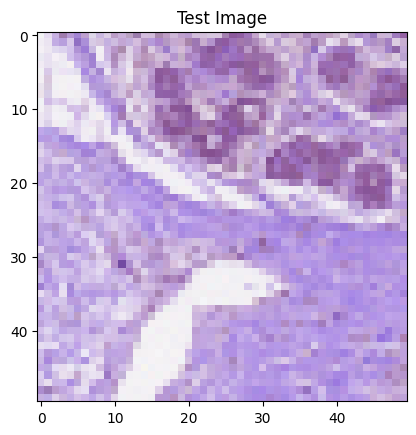

In [18]:
def img_plot(arr,index=0):
    plt.title('Test Image')
    plt.imshow(arr[index])

index = 1000
img_plot(X_test, index)

In [19]:
def img_plot(arr,index=0):
    plt.title('Test Image')
    plt.imshow(arr[index])
index = 4000
input = X_test[index:index+1]
pred = model.predict(input)[0].argmax()
label = Y_test[index].argmax()
print('Predicted Value using  cnn model',pred)
print("True Value",label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted Value using  cnn model 0
True Value 0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


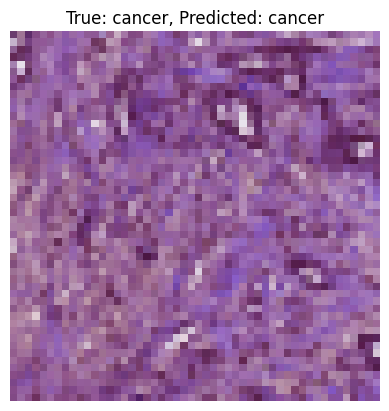

In [20]:
import matplotlib.pyplot as plt
import random
import numpy as np

# Menggunakan gambar dari dataset untuk pengujian
index = random.randint(0, len(X_test) - 1)
input_img = X_test[index:index+1]
true_label = Y_test[index].argmax()
predicted_label = model.predict(input_img)[0].argmax()

# Plot gambar dan prediksi
plt.imshow(X_test[index].astype('uint8'))
plt.title(f'True: {"no cancer" if true_label == 0 else "cancer"}, Predicted: {"no cancer" if predicted_label == 0 else "cancer"}')
plt.axis('off')
plt.show()


In [21]:
model.save("model.h5")

In [23]:
import tensorflow as tf

model = tf.keras.models.load_model('model.h5')
tf.saved_model.save(model, 'saved_model')

INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets
